# Distribution of the lengths of the proteins
**for the different species (reference proteomes)**

## Import python modules

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os 
import pandas as pd
import math

# BASE_PATH
system = list(os.uname())[0]
if system == 'Linux':
    BASE_PATH = "/media/emuro/Nubya/"
elif system == 'Darwin':
    BASE_PATH = "/Volumes/Nubya/"  # or Wes; BIRD
LENofGENES_BASE_PATH = BASE_PATH + "results/geneLength/"

STAT_FILE_SPECIES_PATH = "../../../main_tables/"
ENSEMBL_TAXID_PATH = STAT_FILE_SPECIES_PATH + "extra_tables/"
GO_PATH = "/home/emuro/Desktop/peak_receptors/ensembl_annotation__cavia_porcellus/AmiGO_and_biomart/"

## The protein length distributions for the different species

### Retrieving the statistical descriptions of the length's distributions

In [17]:
# statistics on length distribution for different species     
stat_file = STAT_FILE_SPECIES_PATH + "stat_proteins.tsv"
print("The statistical descriptions of the protein distributions for the different species is in:\n", stat_file, "\n")

# retrieve data and diminish the number of columns
stat_df = pd.read_csv(stat_file, low_memory=False, sep="\t")
stat_df = stat_df[["superregnum", "species", "proteome_id", "tax_id", "uniprot_fasta_file", "count", "mean", "var"] + ["log10_mean", "log10_var"]]

# visualize data
pd.set_option('display.max_columns', None)
if 1:
    display(stat_df.head(2))
    print(stat_df.shape)
    print(stat_df["superregnum"].value_counts())

The statistical descriptions of the protein distributions for the different species is in:
 ../../../main_tables/stat_proteins.tsv 



,superregnum,species,proteome_id,tax_id,uniprot_fasta_file,count,mean,var,log10_mean,log10_var
0,bacteria,Kurthia sp. 3B1D,UP000288623,1562256,/ftp.uniprot.org/pub/databases/uniprot/current...,3621.0,285.936205,36171.895653,2.372531,0.075378
1,bacteria,Methyloprofundus sedimenti,UP000191980,1420851,/ftp.uniprot.org/pub/databases/uniprot/current...,3608.0,310.654933,52309.438700,2.393412,0.087226


(9913, 10)
superregnum
bacteria     7997
eukaryota    1586
archaea       330
Name: count, dtype: int64


## Python functions

In [18]:
# species' stats for length distribution
def get_df_for_taxid(df, taxid):
     return df.loc[df["tax_id"]==taxid].copy()

In [19]:
#### Function to plot the log-normal distribution
# blue: Observation
# red: Theoretical/Simulation
##########################################
def plot_log_norm (log10_len, mu, sigma, N, title, subtitle, xlabel, ylabel): # N is number of 
    print("µ:", mu, "\tσ:", sigma)
    my_normal_dist = np.random.normal(mu, sigma, N)
    count, bins, *rest = plt.hist(log10_len, 60, density=True, alpha=0.8, edgecolor='black') # plot 60 bins

    # plt.hist(my_normal_dist, 30, density=True, alpha=0.25, color="r")
    # print(count); print(bins); print(*rest)
    
    plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
             np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
             linewidth=2, color='r', alpha=0.5)
     
    # mean
    plt.vlines(x = mu, ymin = 0, ymax = 0.2, colors = 'white', label = 'mean')
    plt.xlim([1,7]); plt.ylim([0,2.0])
    plt.suptitle(title, style='italic'); plt.title(subtitle + " (" + str(int(N)) +")")
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.show()

In [20]:
def does_it_fits_normal(data_observed): 
    # Kurtosis and Skewness
    # =====================
    print('Kurtosis:', stats.kurtosis(data_observed))
    print('Skewness:', stats.skew(data_observed))
    # D'Agostino's K-squared test
    # ===========================
    k2, p_value = stats.normaltest(data_observed)
    print(f"D'Agostino's K-squared test(statistics={k2}, p-value={p_value})")
    #
    # Mathematicaly it ends up beeing a theoretical log-normal when.
    #    - Kurtosis o Skewness: $\leq -1$ o $\geq 1$ 
    #    - D'Agostino's K-squared test: p-value $ \leq 0.05 $, becuase it rejects the null hypothesis 

In [51]:
# The next function performs the whole analysis for a tax_id
def species_distribution__retrieve_plot_and_fit(stat_df, tax_id):
    species_df = get_df_for_taxid(stat_df, tax_id)
    species_df.drop_duplicates(subset=['tax_id'], inplace=True, keep='last')
    display(species_df)

    lengths_f = BASE_PATH + "results/geneLength/" + species_df["uniprot_fasta_file"].item() 
    lengths_f = lengths_f.replace(".fasta.gz", ".length.tsv") # I get the 
    print(lengths_f)
    
    # retrieve data
    lens_df = pd.read_csv(lengths_f, sep="\t")
    lens_df = lens_df[["length"]]
    # visualize data
    pd.set_option('display.max_columns', None)
    if 0:
        display(lens_df.head(2))
        print(lens_df.shape)
    
    # plot the distributions: observed and theoretical
    lens_df["log10_length"] = lens_df["length"].apply(np.log10)
    title = species_df["species"].item().capitalize(); subtitle = "Proteins";  xlabel = "$log_{10}(length)$"; ylabel = "Probability density function"
    plot_log_norm (lens_df["log10_length"], species_df["log10_mean"].item(), math.sqrt(species_df["log10_var"].item()), int(species_df["count"].item()), 
                   title, subtitle, xlabel, ylabel)  
    # fit to normal
    does_it_fits_normal(lens_df["log10_length"])



# The next function performs the whole analysis for a tax_id
def species_distribution__retrieve_filter_plot_and_fit(stat_df, tax_id, filt_prots_l):
    species_df = get_df_for_taxid(stat_df, tax_id)
    species_df.drop_duplicates(subset=['tax_id'], inplace=True, keep='last')
    display(species_df)

    lengths_f = BASE_PATH + "results/geneLength/" + species_df["uniprot_fasta_file"].item() 
    lengths_f = lengths_f.replace(".fasta.gz", ".length.tsv") # I get the 
    print(lengths_f)
    
    # retrieve data
    lens_df = pd.read_csv(lengths_f, sep="\t")


    cond = ~lens_df["UniprotID"].isin(filt_prots_l)
    lens_df = lens_df[cond]

    
    lens_df = lens_df[["length"]]
    # visualize data
    pd.set_option('display.max_columns', None)
    if 0:
        display(lens_df.head(2))
        print(lens_df.shape)
    
    # plot the distributions: observed and theoretical
    lens_df["log10_length"] = lens_df["length"].apply(np.log10)
    title = species_df["species"].item().capitalize(); subtitle = "Proteins";  xlabel = "$log_{10}(length)$"; ylabel = "Probability density function"
    plot_log_norm (lens_df["log10_length"], species_df["log10_mean"].item(), math.sqrt(species_df["log10_var"].item()), int(species_df["count"].item()), 
                   title, subtitle, xlabel, ylabel)  
    # fit to normal
    does_it_fits_normal(lens_df["log10_length"])

## Distributions for different species:

## Fig S2

### _Cavia porcellus_ (tax\_id = 10141)

,superregnum,species,proteome_id,tax_id,uniprot_fasta_file,count,mean,var,log10_mean,log10_var
3646,eukaryota,Cavia porcellus (Guinea pig),UP000005447,10141,/ftp.uniprot.org/pub/databases/uniprot/current...,18247.0,540.943169,246132.162669,2.6082,0.107282


/media/emuro/Nubya/results/geneLength//ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/reference_proteomes/Eukaryota/UP000005447/UP000005447_10141.length.tsv
µ: 2.6081999542155296 	σ: 0.3275391435998644


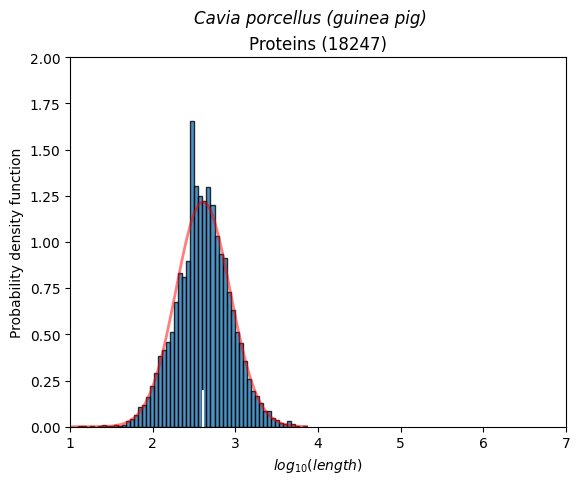

Kurtosis: 0.453719686546751
Skewness: -0.02500681788721736
D'Agostino's K-squared test(statistics=107.87728120235484, p-value=3.7561767965780544e-24)


In [52]:
species_name = "cavia_porcellus"
tax_id = 10141
species_distribution__retrieve_plot_and_fit(stat_df, tax_id)

### Get uniprot ids of species to be filtered

In [53]:
sr_prots_f = GO_PATH + "uniqUniprotKB_sensoryPerception_and_receptor__biomart.txt"
sr_prots_df = pd.read_csv(sr_prots_f, sep="\s+")
sr_prots_df = sr_prots_df.rename(columns = {'UniProtKB_ID':'uniprot_id'})
print(sr_prots_df)
sr_prots_l = sr_prots_df["uniprot_id"].unique().tolist()
num_of_sr_prots = len(sr_prots_l)
print("There are", len(sr_prots_l), "prots")
if 0:
    print(sr_prots_l, "prots")

if 0:
    sr_prots_df = genes_df[genes_df["gene_id"].isin(sr_genes_l)]
    if 1:
        print("Sensory receptors genes are in:", sr_genes_f, "\ngenes_df:\n", sr_prots_df.head(2))
        print(sr_prots_df.shape)
        print(len(sr_prots_df['gene_id'].unique()))

      uniprot_id
0     A0A286X716
1     A0A286X791
2     A0A286X799
3     A0A286X7A5
4     A0A286X7C9
...          ...
1118      P47745
1119      P60987
1120      Q08782
1121      Q6R5A3
1122      Q9EQQ8

[1123 rows x 1 columns]
There are 1123 prots


In [54]:
species_df = get_df_for_taxid(stat_df, tax_id)
lengths_f = BASE_PATH + "results/geneLength/" + species_df["uniprot_fasta_file"].item() 
lengths_f = lengths_f.replace(".fasta.gz", ".length.tsv") # I get the 
print(lengths_f)    

# retrieve data
prots_df = pd.read_csv(lengths_f, sep="\t")
print(prots_df.head(2))
#prots_df = prots_df[["length"]]


sr_prots_df = prots_df[prots_df["UniprotID"].isin(sr_prots_l)]
if 1:
    print("Sensory receptors genes are in:", sr_prots_f, "\nprots_df:\n", sr_prots_df.head(2))
    print(sr_prots_df.shape)
    print(len(sr_prots_df['UniprotID'].unique()))


/media/emuro/Nubya/results/geneLength//ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/reference_proteomes/Eukaryota/UP000005447/UP000005447_10141.length.tsv
   db   UniprotID         EntryName              ProteinName               OS  \
0  sp      P34966         NMU_CAVPO           Neuromedin-U-9  Cavia porcellus   
1  tr  A0A286XFJ6  A0A286XFJ6_CAVPO  Uncharacterized protein  Cavia porcellus   

      OX   GN  PE  SV  length  diffLength  
0  10141  NMU   1   1       9           1  
1  10141  NaN   4   1      10           1  
Sensory receptors genes are in: /home/emuro/Desktop/peak_receptors/ensembl_annotation__cavia_porcellus/AmiGO_and_biomart/uniqUniprotKB_sensoryPerception_and_receptor__biomart.txt 
prots_df:
      db UniprotID     EntryName                 ProteinName               OS  \
156  tr    H0VG61  H0VG61_CAVPO  G protein subunit gamma 13  Cavia porcellus   
191  tr    H0VDL2  H0VDL2_CAVPO   60S ribosomal protein L38  Cavia porcellus   

        OX    

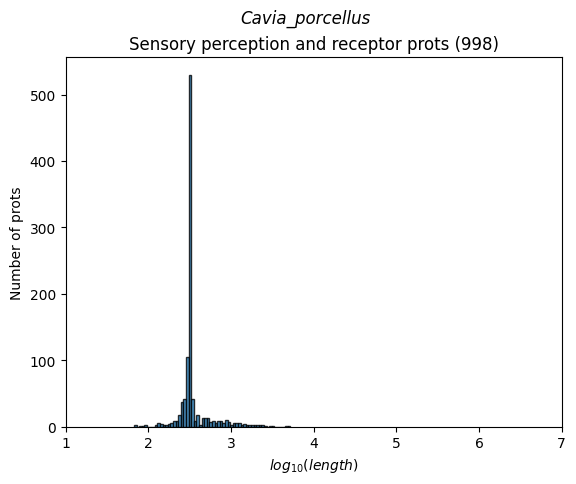

In [55]:
count, bins, *rest = plt.hist(np.log10(sr_prots_df.length.to_list()), 60, density=False, alpha=0.8, edgecolor='black') # plot 60 bins
if 0:
    print(count, bins)
    
title = species_name.capitalize(); subtitle = "Sensory perception and receptor prots";  xlabel = "$log_{10}(length)$"; ylabel = "Number of prots"
plt.xlim([1,7]); 
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.suptitle(title, style='italic'); plt.title(subtitle + " (" + str(sr_prots_df.shape[0]) +")")
#    plt.xlabel(xlabel); plt.ylabel(ylabel)
plt.show()

,superregnum,species,proteome_id,tax_id,uniprot_fasta_file,count,mean,var,log10_mean,log10_var
3646,eukaryota,Cavia porcellus (Guinea pig),UP000005447,10141,/ftp.uniprot.org/pub/databases/uniprot/current...,18247.0,540.943169,246132.162669,2.6082,0.107282


/media/emuro/Nubya/results/geneLength//ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/reference_proteomes/Eukaryota/UP000005447/UP000005447_10141.length.tsv
µ: 2.6081999542155296 	σ: 0.3275391435998644


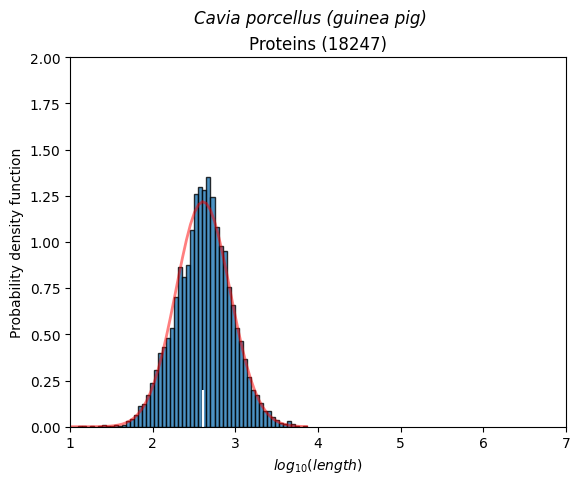

Kurtosis: 0.36077001570389466
Skewness: -0.0732207911633885
D'Agostino's K-squared test(statistics=83.64326865712091, p-value=6.872187289596877e-19)


In [56]:
tax_id = 10141
ylim = [0., 0.65]; bool_ylim = True

# plot the dist
species_distribution__retrieve_filter_plot_and_fit(stat_df, tax_id, sr_prots_l)